In [1]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/aiken516/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
#from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

import time

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 385 (delta 22), reused 35 (delta 17), pack-reused 340
Receiving objects: 100% (385/385), 45.38 MiB | 29.43 MiB/s, done.
Resolving deltas: 100% (220/220), done.
renamed 'one-pixel-attack-keras/1_one_pixel_attack_cifar10.ipynb' -> './1_one_pixel_attack_cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './L

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

In [5]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet] #, resnet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet


In [25]:
def pixel_confidence(image_id):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    target_count = np.zeros(10, dtype=int)

    helper.plot_image(img_original)

    prior_confidence =  model.predict_one(img_original)
    print("prior_confidence: {0}".format(prior_confidence[true_class]))

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    array = np.empty((0, 32, 32, 3))

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img_original)

          array = np.append(array, np.array((perturbed_image)), axis=0)

    processed = model.color_process(array)
    result = model._model.predict(processed, batch_size=1024,verbose=0)

    for i in range(1024):
        target_count[np.argmax(result[i] - prior_confidence)] += 1

    target_class = np.argmax(target_count)
    print("target_class: {0}".format(class_names[target_class]))

    for i in range(1024):
        after_confidence =  result[i][target_class]
        #print("after_confidence: {0}".format(after_confidence))

        diff_confidence = abs(after_confidence - prior_confidence[target_class])
        #print("diff_confidence: {0}".format(diff_confidence))

        if diff_confidence > 0:
            for diff_index in range(len(diff_list)):
                if diff_confidence >= diff_list[diff_index][1]:
                    diff_list.insert(diff_index, [i, diff_confidence])
                    if (len(diff_list) > 30):
                        diff_list.pop()
                    break

    return diff_list[0][0]

In [32]:
def pixel_confidence(image_id):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    target_count = np.zeros(10, dtype=int)

    helper.plot_image(img_original)

    prior_confidence =  model.predict_one(img_original)
    print("prior_confidence: {0}".format(prior_confidence[true_class]))

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    array = np.empty((0, 32, 32, 3))

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img_original)

          array = np.append(array, np.array((perturbed_image)), axis=0)

    processed = model.color_process(array)
    result = model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence

    for i in range(1024):
        target_count[np.argmax(result[i])] += 1

    target_class = np.argmax(target_count)
    print("target_class: {0}".format(class_names[target_class]))

    for i in range(1024):
        diff_confidence =  result[i][target_class]

        if diff_confidence > 0:
            for diff_index in range(len(diff_list)):
                if diff_confidence >= diff_list[diff_index][1]:
                    diff_list.insert(diff_index, [i, diff_confidence])
                    if (len(diff_list) > 30):
                        diff_list.pop()
                    break

    return diff_list[0][0], target_count

In [11]:
def gradient_descent_momentum(image_id, pixel):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    x = pixel[0]
    y = pixel[1]
    r = pixel[2]
    g = pixel[3]
    b = pixel[4]

    rate = 5000
    momentum_rate = 0.99

    v_r = 0 #속도
    v_g = 0
    v_b = 0

    for i in range(100):
        node = np.array([x, y, r, g, b])
        ori_con = model.predict_one(perturb_image(node, img))[true_class]

        #if (ori_con < 0.5):
        #    return True

        print("x:{0}, y:{1}, rgb:({2}, {3}, {4}), confidence: {5})".format(x, y, r, g, b, ori_con))
        array = np.empty((0, 32, 32, 3))

        array = np.append(array, np.array((perturb_image(np.array([x, y, bound(r + 1), g, b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, bound(r - 1), g, b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, bound(g + 1), b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, bound(g - 1), b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, g, bound(b + 1)]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, g, bound(b - 1)]), img))), axis=0)

        processed = model.color_process(array)
        result = model._model.predict(processed, batch_size=6, verbose=0)

        diff_r = result[0][true_class] - result[1][true_class]
        print("diff_r: {0}".format(diff_r))

        diff_g = result[2][true_class] - result[3][true_class]
        print("diff_g: {0}".format(diff_g))

        diff_b = result[4][true_class] - result[5][true_class]
        print("diff_b: {0}".format(diff_b))

        v_r = momentum_rate * v_r - diff_r * rate
        v_g = momentum_rate * v_g - diff_g * rate
        v_b = momentum_rate * v_b - diff_b * rate

        if (abs(diff_r) + abs(diff_g) + abs(diff_b) < 0.0001):
            break

        new_r = bound(r + v_r)
        new_g = bound(g + v_g)
        new_b = bound(b + v_b)

        #if (new_r == r and new_g == g and new_b == b):
        #    break

        r = new_r
        g = new_g
        b = new_b

    helper.plot_image(perturb_image(np.array([x, y, r, g, b]), img))
    print("Attack Confidence:" + str(model.predict_one(perturb_image(np.array([x, y, r, g, b]), img))[true_class]))

def bound(num):
    return int(max(0, min(255,num)))

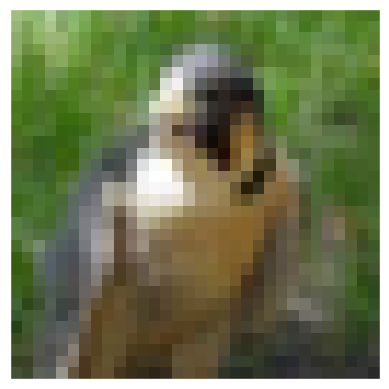

1/1 [==============================] - 0s 52ms/step
prior_confidence: 0.7066169381141663
target_class: dog
559
[  0   0 365   0   0 658   1   0   0   0]


In [33]:
model = resnet
image_id = 384

diff_num, target_count = pixel_confidence(image_id)
print(diff_num)
print(target_count)
x = diff_num // 32
y = diff_num % 32
pixel = np.array([x, y, x_test[image_id][x][y][0], x_test[image_id][x][y][1], x_test[image_id][x][y][2]])

#gradient_descent_momentum(image_id, pixel)

In [9]:
def gradient_ascent_momentum_target(image_id, pixel, target_class):
    img = x_test[image_id]

    x = pixel[0]
    y = pixel[1]
    r = pixel[2]
    g = pixel[3]
    b = pixel[4]

    rate = 1000
    momentum_rate = 0.99

    v_r = 0 #속도
    v_g = 0
    v_b = 0

    for i in range(1000):
        node = np.array([x, y, r, g, b])

        print("x:{0}, y:{1}, rgb:({2}, {3}, {4}), confidence: {5})".format(x, y, r, g, b, model.predict_one(perturb_image(node, img))[target_class]))

        array = np.empty((0, 32, 32, 3))

        array = np.append(array, np.array((perturb_image(np.array([x, y, bound(r + 1), g, b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, bound(r - 1), g, b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, bound(g + 1), b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, bound(g - 1), b]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, g, bound(b + 1)]), img))), axis=0)
        array = np.append(array, np.array((perturb_image(np.array([x, y, r, g, bound(b - 1)]), img))), axis=0)

        processed = model.color_process(array)
        result = model._model.predict(processed, batch_size=6, verbose=0)

        diff_r = result[0][target_class] - result[1][target_class]
        #print("diff_r: {0}".format(diff_r))

        diff_g = result[2][target_class] - result[3][target_class]
        #print("diff_g: {0}".format(diff_g))

        diff_b = result[4][target_class] - result[5][target_class]
        #print("diff_b: {0}".format(diff_b))

        v_r = momentum_rate * v_r + diff_r * rate
        v_g = momentum_rate * v_g + diff_g * rate
        v_b = momentum_rate * v_b + diff_b * rate

        new_r = bound(r + v_r)
        new_g = bound(g + v_g)
        new_b = bound(b + v_b)

        if (new_r == r and new_g == g and new_b == b):
            break

        r = new_r
        g = new_g
        b = new_b

    helper.plot_image(perturb_image(np.array([x, y, r, g, b]), img))
    print("Attack Confidence:" + str(model.predict_one(perturb_image(np.array([x, y, r, g, b]), img))[target_class]))

def bound(num):
    return int(max(0, min(255,num)))

In [8]:
model = resnet
image_id = 384

diff_num = pixel_confidence(image_id)
print(diff_num)
x = diff_num // 32
y = diff_num % 32
pixel = np.array([x, y, x_test[image_id][x][y][0], x_test[image_id][x][y][1], x_test[image_id][x][y][2]])

for i in range(10):
    gradient_ascent_momentum_target(image_id, pixel, i)

NameError: ignored

In [7]:
# Fixing gradient due to the number of calling predict function

def score_init(sensitive_x, sensitive_y, r, g, b, img, model, momentum, learning_rate, target_class):

    true_class = y_test[image_id, 0]
    vr, vg, vb = 0, 0, 0
    print(r, g, b)

    batch_List = np.empty((0, 32, 32, 3))

    decr_red = np.array([sensitive_x, sensitive_y, bound(r-1), g, b])
    perturbed_d_Red = perturb_image(decr_red, img)
    incr_red = np.array([sensitive_x, sensitive_y, bound(r+1), g, b])
    perturbed_i_Red = perturb_image(incr_red, img)

    batch_List = np.append(batch_List, np.array(perturbed_d_Red), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Red), axis = 0)
    #decr_red_confidence = model.predict_one(perturb_image(decr_red, img))[target_class]
    #incr_red_confidence = model.predict_one(perturb_image(incr_red, img))[target_class]

    #diff_r = (incr_red_confidence - decr_red_confidence)
    #print(diff_r)

    decr_green = np.array([sensitive_x, sensitive_y, r, bound(g-1), b])
    perturbed_d_Green = perturb_image(decr_green, img)
    incr_green = np.array([sensitive_x, sensitive_y, r, bound(g+1), b])
    perturbed_i_Green = perturb_image(incr_green, img)

    batch_List = np.append(batch_List, np.array(perturbed_d_Green), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Green), axis = 0)
    #decr_green_confidence = model.predict_one(perturb_image(decr_green, img))[target_class]
    #incr_green_confidence = model.predict_one(perturb_image(incr_green, img))[target_class]


    #diff_g = (incr_green_confidence - decr_green_confidence)
    #print(diff_g)

    decr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b-1)])
    perturbed_d_Blue = perturb_image(decr_blue, img)
    incr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b+1)])
    perturbed_i_Blue = perturb_image(incr_blue, img)

    batch_List = np.append(batch_List, np.array(perturbed_d_Blue), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Blue), axis = 0)
    #decr_blue_confidence = model.predict_one(perturb_image(decr_blue, img))[target_class]
    #incr_blue_confidence = model.predict_one(perturb_image(incr_blue, img))[target_class]

    processed = model.color_process(batch_List)
    ConfidenceList = model._model.predict(processed, batch_size = 6, verbose = 0) # decr_red_confidence = result[0][target_class]


    #diff_b = (incr_blue_confidence - decr_blue_confidence)
    #print(diff_b)

    diff_r = (ConfidenceList[1][target_class] - ConfidenceList[0][target_class])
    diff_g = (ConfidenceList[3][target_class] - ConfidenceList[2][target_class])
    diff_b = (ConfidenceList[5][target_class] - ConfidenceList[4][target_class])

    vr = momentum * vr + learning_rate * diff_r # r axis vector
    vg = momentum * vg + learning_rate * diff_g # g axis vector
    vb = momentum * vb + learning_rate * diff_b # b axis vector

    #print(vr, vg, vb)
    new_r = bound(r + vr)
    new_g = bound(g + vg)
    new_b = bound(b + vb)

    xs = np.array([sensitive_x, sensitive_y, new_r, new_g, new_b])
    #print("new rgb is : ", new_r, new_g, new_b)
    predicted_probs = model.predict_one(perturb_image(xs, img))


    predicted_class = np.argmax(predicted_probs)
    #print("init end\n")

    return new_r, new_g, new_b, predicted_probs, vr, vg, vb

In [6]:
def score_based_attack(image_id, model, sensitive_x, sensitive_y, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    original_confidence = model.predict_one(img) # will be deleted during experiment
    print("original confidence is : ", original_confidence[true_class], '\n')

    # Original rgb value, named Prev (original is initial Prev)
    prev_r = img[sensitive_x][sensitive_y][0]
    prev_g = img[sensitive_x][sensitive_y][1]
    prev_b = img[sensitive_x][sensitive_y][2]
    print("original rgb is : ", prev_r, prev_g, prev_b)

    momentum = 0.9 # widely used
    learning_rate = 5000 # hyperparameter,
    # velocity = 0 # velocity, initialized with 0

    iteration_num = 20 # num of iteration, hyperparameter
    terminate_constant = 0.01 # termination constant, compare with original class's confidence

    start_point = [[0,0,0], [0,0,255], [0,255,0], [255,0,0], [0,255,255], [255,0,255], [255,255,0], [255,255,255]]

    sensitive_coordinate = np.array([sensitive_x, sensitive_y])
    print("Sen : ", sensitive_coordinate)
    Xs_List = [] # Note that Xs is 5-tuple of (x,y,r,g,b)

    print("Startpoint : ", startPoint[0])

    # Xs_List will be previous state
    for i in range(len(start_point)):
        Xs_List.append(np.concatenate((sensitive_coordinate, startPoint[i]), axis = 0))

    Xs_List = np.array(Xs_List).reshape((8,5))

    image_List = np.empty((0, 32, 32, 3))

    # temp = perturb_image(Xs_List[0], img)
    # helper.plot_image(temp)
    for i in range(len(Xs_List)):
        perturbed_image = perturb_image(Xs_List[i], img)
        image_List = np.append(image_List, np.array(perturbed_image), axis = 0)

    processed = model.color_process(image_List)
    Prev_Probs = model._model.predict(processed, batch_size = 8, verbose = 0)
    # result is a list of predicted results perturbed with [0, 0, 0], [0, 0, 255], ... , [255, 255, 255]
    #print(Prev_Probs[0])

    # result[i]기 previous probs 역할, next probs는 init으로 받고..

    Next_State_List = np.empty((8,5)) # np.array of [x, y, r, g, b] * 8
    Next_Probs = [] # 8 predicted results
    velocityList = [] # each state's velocity

    for i in range(len(startPoint)):
        new_r, new_g, new_b, next_probs, vr, vg, vb = score_init(sensitive_x, sensitive_y, startPoint[i][0], startPoint[i][1], startPoint[i][2], img, model, momentum, learning_rate, target_class)
        temp = np.array([new_r, new_g, new_b])

        Next_State_List = np.append(Next_State_List, np.concatenate((sensitive_coordinate, temp), axis = 0))
        Next_Probs.append(next_probs)
        velocityList.append([vr, vg, vb])

    #print(Next_Probs[0])
    print(Next_State_List[0][0])

    for i in range(len(Xs_List)):
        continue_flag = True

        for t in range(3):
            if(Next_State_List[i][t+2] != Xs_List[i][t+2]):
                continue_flag = False
        if(continue_flag):
            continue

        for j in range(iteration_num):

            r_difference = (Next_State_List[i][2] - Xs_List[i][2]) if (Next_State_List[i][2] - Xs_List[i][2]) != 0 else 1
            g_difference = (Next_State_List[i][3] - Xs_List[i][3]) if (Next_State_List[i][3] - Xs_List[i][3]) != 0 else 1
            b_difference = (Next_State_List[i][4] - Xs_List[i][4]) if (Next_State_List[i][4] - Xs_List[i][4]) != 0 else 1

            r_Slope = (Next_Probs[i][target_class] - Prev_Probs[i][target_class]) / r_difference
            g_Slope = (Next_Probs[i][target_class] - Prev_Probs[i][target_class]) / g_difference
            b_Slope = (Next_Probs[i][target_class] - Prev_Probs[i][target_class]) / b_difference

            velocityList[i][0] = momentum * velocityList[i][0] + learning_rate * r_Slope
            velocityList[i][1] = momentum * velocityList[i][1] + learning_rate * g_Slope
            velocityList[i][2] = momentum * velocityList[i][2] + learning_rate * b_Slope

            New_r = bound(Next_State_List[i][2] + velocityList[i][0])
            New_g = bound(Next_State_List[i][3] + velocityList[i][1])
            New_b = bound(Next_State_List[i][4] + velocityList[i][2])

            xs = np.array([sensitive_x, sensitive_y, New_r, New_g, New_b])

            predicted_probs = model.predict_one(perturb_image(xs, img)) # will be deleted during experiment
            predicted_class = np.argmax(predicted_probs)
            print(str(i) + "th round's original class's confidence : ", predicted_probs[true_class])
            print(str(i) + "th round's predicted class's confidence : ", predicted_probs[predicted_class])

            helper.plot_image(perturb_image(xs, x_test[image_id])[0], true_class, class_names, predicted_class)

            if(New_r == Next_State_List[i][2] and New_g == Next_State_List[i][3] and New_b == Next_State_List[i][4]):
                print("Failure") # print for test, will be deleted

            Prev_Probs[i] = Next_Probs[i]
            Next_Probs[i] = predicted_probs

            Xs_List[i][2], Xs_List[i][3], Xs_List[i][4] = Next_State_List[i][2], Next_State_List[i][3], Next_State_List[i][4]

            Next_State_List[i][2], Next_State_List[i][3], Next_State_List[i][4] = New_r, New_g, New_b

In [ ]:
image_id = 384
model = resnet
sen_list, target_class = sensitive_pixel_sorting_win(image_id, model = resnet)
sensitive_ranking = 0
x = sen_list[sensitive_ranking][0]
y = sen_list[sensitive_ranking][1]
Score_based_attack(image_id, model, x, y, target_class)